In [1]:
from huggingface_hub import login
login(token='XXX')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Install required packages

In [2]:
%%capture
%pip install pyarrow==15.0.2
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

Need to install this particular pyarrow version to avoid issues with datasets

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

Load and initialize the model, the tokenizer and the pipe function from transformers library

In [9]:
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
import torch

base_model = "meta-llama/Llama-2-7b-hf"
#base_model = "/kaggle/input/llama-3.1/transformers/8b/1"

tokenizer = AutoTokenizer.from_pretrained(base_model)

model = AutoModelForCausalLM.from_pretrained(
        base_model,
        return_dict=True,
        low_cpu_mem_usage=True,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [10]:
tokenizer('Hello how are you')

{'input_ids': [1, 15043, 920, 526, 366], 'attention_mask': [1, 1, 1, 1, 1]}

Load the dataset

In [11]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/test_food_bev_alc.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [12]:
df['Category']=[df['label'][i].split('/')[0] for i in range(len(df))]
df['Sub-Category']=[df['label'][i].split('/')[1] for i in range(len(df))]
df.drop(['link','typeID'],axis=1,inplace=True)
print(df.sample(3))
print(df['Category'].unique())
print(df['Sub-Category'].unique())

                                                 product  \
62369      Jelly Belly Jelly Beans, Smoothie Blend3.5 oz   
65351  Once Upon a Farm Immunity Blend Pineapple, Ban...   
31213             Rouses Large Fresh Honeydew Chunkseach   

                                                   label Category  \
62369               food/pantry/snacks/candy/jelly beans     food   
65351           food/pantry/snacks/squeeze snack pouches     food   
31213  food/fresh produce/fresh fruit/melons/honeydew...     food   

        Sub-Category  
62369         pantry  
65351         pantry  
31213  fresh produce  
['alcohol' 'beverages' 'food']
['beer' 'alcohol making kits' 'cocktail accessories' 'spirits' 'wine'
 'coffee' 'juice' 'powdered drinks' 'soda' 'tea' 'water' 'deli'
 'baked goods' 'dairy' 'meat' 'seafood' 'fresh produce' 'frozen food'
 'meat alternatives' 'pantry']


In [19]:
labels=df.Category.unique()
min_val=min(df.Category.value_counts())
df.Category.value_counts()

,count
Category,
food,64466
alcohol,8013
beverages,3464


In [35]:
sub_df=df["Sub-Category"].value_counts()
sub_df

,count
Sub-Category,
pantry,24499
fresh produce,13952
frozen food,5987
meat,5965
baked goods,4201
dairy,4026
wine,3829
deli,3146
seafood,2169


Balance the data set

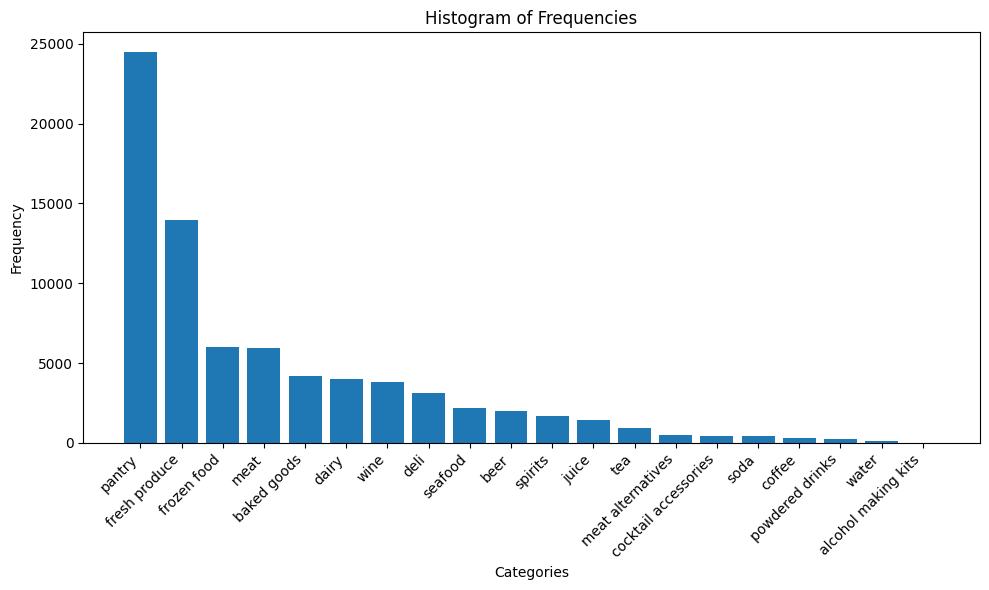

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(sub_df.index, sub_df.values)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Histogram of Frequencies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Balancing the data set and train test split. We save part of the data for evaluation before fine-tuning

In [37]:
food=df[df['Category'] == 'food'].sample(n=min_val,random_state=34)
alcohol=df[df['Category'] == 'alcohol'].sample(n=min_val,random_state=34)
beverages=df[df['Category'] == 'beverages']

In [38]:
balanced_df = pd.concat([food, alcohol, beverages])

In [39]:
balanced_df.Category.value_counts()

,count
Category,
food,3464
alcohol,3464
beverages,3464


In [40]:
balanced_df = balanced_df.sample(frac=1, random_state=85).reset_index(drop=True)

# Split the DataFrame
train_size = 0.8
eval_size = 0.1

# Calculate sizes
train_end = int(train_size * len(balanced_df))
eval_end = train_end + int(eval_size * len(balanced_df))

# Split the data
X_train = balanced_df[:train_end]
X_eval = balanced_df[train_end:eval_end]
X_test = balanced_df[eval_end:]


In [41]:
X_train.Category.value_counts()

,count
Category,
food,2789
alcohol,2762
beverages,2762


In [42]:
X_test.Category.value_counts()

,count
Category,
food,357
beverages,352
alcohol,331


In [43]:
# Define the prompt generation functions
def generate_train_prompt(data_point):
    return f"""
            Classify the text into {labels[0]}, {labels[1]} or {labels[2]} and return the answer as the corresponding label.
text: {data_point["product"]}
label: {data_point["Category"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into {labels[0]}, {labels[1]} or {labels[2]} and return the answer as the corresponding label.
text: {data_point["product"]}
label: """.strip()

X_train = X_train.copy()
X_eval = X_eval.copy()

# Generate prompts for training and evaluation data
X_train.loc[:,'text'] = X_train.apply(generate_train_prompt, axis=1)
X_eval.loc[:,'text'] = X_eval.apply(generate_train_prompt, axis=1)

# Generate test prompts and extract true labels
y_true = X_test.loc[:,'Category']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

In [44]:
from datasets import Dataset

# Convert to datasets for Hugginface
train_data = Dataset.from_pandas(X_train[["text"]])
eval_data = Dataset.from_pandas(X_eval[["text"]])

In [45]:
def predict(test, model, tokenizer):
    y_pred = []
    y_raw = []
    categories = balanced_df.Category.unique()

    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens=2,
                        temperature=0.1)

        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()
        if answer == 'beverage':
          answer = 'beverages'

        y_raw.append(answer)

        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred, y_raw

y_pred, y_raw = predict(X_test, model, tokenizer)

100%|██████████| 1040/1040 [02:40<00:00,  6.48it/s]


In [55]:
set(y_raw)

{'Food', 'alcohol', 'beer', 'bever', 'beverages', 'food'}

In [56]:
def evaluate(y_true, y_pred):
    #labels = balanced_df.Category.unique()
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    # Calculate accuracy (with accuracy_score in scikitlearn)
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

evaluate(y_true, y_pred)

Accuracy: 0.632
Accuracy for label alcohol: 0.927
Accuracy for label beverages: 0.085
Accuracy for label food: 0.896

Classification Report:
              precision    recall  f1-score   support

     alcohol       0.70      0.93      0.80       331
   beverages       0.91      0.09      0.16       352
        food       0.58      0.90      0.71       357

   micro avg       0.64      0.63      0.64      1040
   macro avg       0.73      0.64      0.55      1040
weighted avg       0.73      0.63      0.55      1040


Confusion Matrix:
[[307   3   5]
 [ 93  30 224]
 [ 37   0 320]]


In [65]:
prompt=X_test.iloc[1]["text"]
print(f"The prompt given is: {prompt}")
pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens=2,
                        temperature=0.1)

result = pipe(prompt)
answer = result[0]['generated_text'].split("label:")[-1].strip()
print(f"Model classification output label: {answer}")

The prompt given is: Classify the text into alcohol, beverages or food and return the answer as the corresponding label.
text: Hi-Wire Brewing Beer, IPA Pitch Pack16 fl oz
label:
Model classification output label: alcohol


In [68]:
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(base_model)

tokenizer.pad_token_id = tokenizer.eos_token_id

In [69]:
from transformers import Conv1D

def get_specific_layer_names(model):
    # Create a list to store the layer names
    layer_names = []

    # Recursively visit all modules and submodules
    for name, module in model.named_modules():
        # Check if the module is an instance of the specified layers
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv2d, Conv1D)):
            # model name parsing

            layer_names.append('.'.join(name.split('.')[4:]).split('.')[0])

    return layer_names

modules=list(set(get_specific_layer_names(model)))
modules=modules[1:]
modules

['q_proj', 'down_proj', 'gate_proj', 'v_proj', 'k_proj', 'o_proj', 'up_proj']

In [70]:
output_dir="llama-fine-tuned-model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=512,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:366: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/8313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1039 [00:00<?, ? examples/s]

In [71]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
208,0.582000,0.730327
416,0.785100,0.702810
624,0.535400,0.683821
832,0.571000,0.672637


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1039, training_loss=0.7416325601335898, metrics={'train_runtime': 3634.9936, 'train_samples_per_second': 2.287, 'train_steps_per_second': 0.286, 'total_flos': 1.5935374849056768e+16, 'train_loss': 0.7416325601335898, 'epoch': 0.9998797064838205})

In [72]:
# Save trained model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-fine-tuned-model/tokenizer_config.json',
 'llama-fine-tuned-model/special_tokens_map.json',
 'llama-fine-tuned-model/tokenizer.model',
 'llama-fine-tuned-model/added_tokens.json',
 'llama-fine-tuned-model/tokenizer.json')

In [75]:
y_pred,y_raw = predict(X_test, model, tokenizer)

100%|██████████| 1040/1040 [04:06<00:00,  4.22it/s]


In [76]:
evaluate(y_true, y_pred)

Accuracy: 0.652
Accuracy for label alcohol: 0.988
Accuracy for label beverages: 0.000
Accuracy for label food: 0.983

Classification Report:
              precision    recall  f1-score   support

     alcohol       0.99      0.99      0.99       331
   beverages       0.00      0.00      0.00       352
        food       0.99      0.98      0.99       357

   micro avg       0.99      0.65      0.79      1040
   macro avg       0.66      0.66      0.66      1040
weighted avg       0.65      0.65      0.65      1040


Confusion Matrix:
[[327   0   2]
 [  2   0   2]
 [  1   0 351]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
for i in range(len(y_raw)):
  if y_raw[i] == 'bever':
    y_pred[i] = 'beverages'

In [79]:
evaluate(y_true, y_pred)

Accuracy: 0.987
Accuracy for label alcohol: 0.988
Accuracy for label beverages: 0.989
Accuracy for label food: 0.983

Classification Report:
              precision    recall  f1-score   support

     alcohol       0.99      0.99      0.99       331
   beverages       0.98      0.99      0.98       352
        food       0.99      0.98      0.99       357

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040


Confusion Matrix:
[[327   2   2]
 [  2 348   2]
 [  1   5 351]]
